<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's lecture using topic modeling: 

- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

# Building the Model

In [0]:
# Imports

# Gensim Imports
import gensim
from gensim import corpora
from gensim.models import CoherenceModel
from gensim.models import LdaMulticore
from gensim.models import Phrases
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns
import spacy

nlp = spacy.load('en_core_web_lg')

In [0]:
# Load in dataframe

path = './data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv'

df = pd.read_csv(path)

df['brand'] = df['brand'].str.lower()  # Send brand to lower for later use.

df.sample()  # Let's see an example entry

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
28155,AVqkIhxunnc1JgDc3kg_,2017-03-06T14:59:43Z,2019-02-23T02:49:38Z,"Fire HD 8 Tablet with Alexa, 8 HD Display, 16 ...",B018T075DC,amazon,"Fire Tablets,Tablets,All Tablets,Amazon Tablet...",Electronics,https://www.upccodesearch.com/images/barcode/0...,"amazon/b018t075dc,firehd8tabletwithalexa8hddis...",...,NaN,True,NaN,0.0,5,http://reviews.bestbuy.com/3545/5620410/review...,I got this for my husband birthday and he love...,Tablet,butterfky,http://reviews.bestbuy.com/3545/5620410/review...


In [0]:
reviews = df['reviews.text'].values.tolist()  # Send review text values to a list

In [0]:
def text_to_words(words):
    for word in words:
        yield(gensim.utils.simple_preprocess(str(word), deacc=True))  # Note: deacc removes punctuation

reviews_text = list(text_to_words(reviews))  # Uses our text_to_words function to split each word from each review into list items.

print(reviews_text[0])

['order', 'of', 'them', 'and', 'one', 'of', 'the', 'item', 'is', 'bad', 'quality', 'is', 'missing', 'backup', 'spring', 'so', 'have', 'to', 'put', 'pcs', 'of', 'aluminum', 'to', 'make', 'the', 'battery', 'work']


In [0]:
# Make a few functions....

# Function to Remove Stopwords
def no_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in STOPWORDS] for doc in texts]  # This will get rid of our stop words.

# Function for Lemmatization
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']): 
    
    text_list = []
    
    for sent in texts:
        doc = nlp(" ".join(sent))  
        text_list.append([token.lemma_.lower() for token in doc if token.pos_ in allowed_postags])  # Tokenize / Append
    return text_list

In [0]:
rev_no_stops = no_stopwords(reviews_text)  # Remove Stop Words

# Lemmatize reviews (pre-processing with custom function)....
rev_lem = lemmatization(rev_no_stops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [0]:
id2word = corpora.Dictionary(rev_lem)  # Create dictionary

corpus = [id2word.doc2bow(text) for text in rev_lem]  # Send to bag of words as our corpus.

## Select Number of Topics & Fit Model

In [0]:
def compute_coherence_values(dictionary, corpus, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : Max num of topics
    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    model_list : List of Models Used
    """
    
    # Empty lists top populate. One for coherence values, one to store model list in memory for easier usage later.
    coherence_values = []
    model_list = [] 
    
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus, id2word=id2word,
                             num_topics=num_topics, random_state=42,
                             chunksize=125, workers=4)  # This is our LDA model.

        coherencemodel = CoherenceModel(model=model, dictionary=dictionary,
                                            corpus=corpus, coherence='u_mass')  # ... And our coherence model.

        coherence_values.append({'num_topics': num_topics, 
                                 'coherence_score': coherencemodel.get_coherence()
                                })  # Appending the number of topics / coherence scores to determine the appropriate number of topics.
        model_list.append(model)  # Saving model in memory because we're gonna only be doing 13 total models - shouldn't be too bad on memory.

    return model_list, coherence_values  # Here we're returning the models stored in memory + their coherence scores and number of topics.

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus,
                                                        start=2, limit=40, step=3)  # Using the function above.

In [0]:
# Print the coherence values. This will tell us the best number of topics

for i, cv in zip(range(len(coherence_values)), coherence_values):
    cv = list(coherence_values)[i].get('coherence_score')  # Fetch coherence value.
    num = list(coherence_values)[i].get('num_topics')  # Fetch the number of topics in accordance to the same index.
    print(f'===========================================\nModel Index: {i} - {num} Topics')  # Print the appropriate index + number of topics (='s for improved readability in printing)
    print("Coherence Value:", cv)  # Print the coherence value for the same index.

Model Index: 0 - 2 Topics
Coherence Value: -2.513540001588426
Model Index: 1 - 5 Topics
Coherence Value: -2.952475569041533
Model Index: 2 - 8 Topics
Coherence Value: -3.7078933778874985
Model Index: 3 - 11 Topics
Coherence Value: -4.127150024976235
Model Index: 4 - 14 Topics
Coherence Value: -3.7857462456628954
Model Index: 5 - 17 Topics
Coherence Value: -4.340369569518515
Model Index: 6 - 20 Topics
Coherence Value: -4.57825419104762
Model Index: 7 - 23 Topics
Coherence Value: -4.488662553687511
Model Index: 8 - 26 Topics
Coherence Value: -4.859629391568297
Model Index: 9 - 29 Topics
Coherence Value: -4.701571188988836
Model Index: 10 - 32 Topics
Coherence Value: -5.213501433702773
Model Index: 11 - 35 Topics
Coherence Value: -5.153423543686911
Model Index: 12 - 38 Topics
Coherence Value: -5.027650712085085


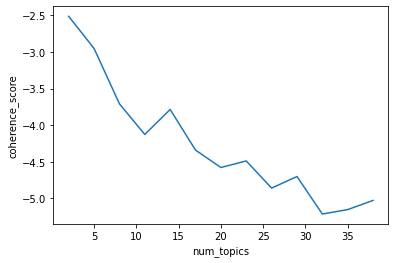

In [0]:
# Visualize for improved understanding of what number of topics we should use.

topic_coherence = pd.DataFrame.from_records(coherence_values)  # Making a pandas dataframe from our coherence values for our visualization.
ax = sns.lineplot(x="num_topics", y="coherence_score", data=topic_coherence)  # This will give us a very good visualization to understand and confirm we're using the proper number of topics.

# Visualizations

In [0]:
# Import
import pyLDAvis.gensim

lda = model_list[3]  # We're using this index from the model list as it is already stored in memory and we know from the code blocks above which index it is.

## Topic Distance Visualization

In [0]:
pyLDAvis.enable_notebook()  # Enable our notebook
pyLDAvis.gensim.prepare(lda, corpus, id2word)  # Display our visualization

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.168470  0.008817       1        1  24.226934
2      0.181930  0.014306       2        1  11.980736
9      0.099149 -0.204094       3        1  11.363995
3      0.151490  0.026921       4        1   8.924830
7      0.045955  0.043036       5        1   8.363300
10     0.094792  0.134779       6        1   7.926849
1     -0.279713 -0.009159       7        1   6.462708
0      0.011487  0.137558       8        1   6.086532
6     -0.100533 -0.327286       9        1   5.219576
8     -0.232513  0.164373      10        1   5.066208
5     -0.140515  0.010750      11        1   4.378333, topic_info=           Term          Freq         Total Category  logprob  loglift
45         good   8166.000000   8166.000000  Default  30.0000  30.0000
19        great  10369.000000  10369.000000  Default  29.0000  29.0000
75         love   6788.000000   6788.000000  Default  28.0000  28.0000
1174       book   4327.000000   4327.000000  Default  27.0000  27.0000
2857     tablet   7622.000000   7622.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
162   available    120.321152    532.854309  Topic11  -4.6400   1.6404
17        price    273.348907   5101.989746  Topic11  -3.8194   0.2019
3       battery    212.144684   3313.214844  Topic11  -4.0729   0.3801
136   recommend    103.097229   1393.347168  Topic11  -4.7945   0.5247
88         need     95.044594   1565.037720  Topic11  -4.8758   0.3272

[670 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
783      11  0.996350     ability
996       3  0.993216        able
996      11  0.004933        able
905       3  0.994709  absolutely
1397      4  0.997905      access
...     ...       ...         ...
87        8  0.000816        year
87       10  0.000816        year
876       6  0.998378       young
1148      8  0.972209         yrs
1456      7  0.951936        zone

[1618 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 10, 4, 8, 11, 2, 1, 7, 9, 6])

## Overall Model and Documents

In [0]:
# Here we will be making our distro updates....

distro = [lda[d] for d in corpus]  # LDA[Document] for Document in our corpus.

def update(doc):
    d_dist = {k:0 for k in range(0, 11)} 
    for t in doc:  # For text in doc...
        d_dist[t[0]] = t[1] # Go through and update each entry in our distro
    return d_dist

new_distro = [update(d) for d in distro]  # Let's use the function above to update the distro. This will be our new distro for looking at our overall model.

In [0]:
brands = df['brand'].values.tolist()  # Send brands to list.
topic_words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]  # Get topic words from lda.
topics = [' '.join(t[0:5]) for t in topic_words]  # Join top five words for usage as topics.

overall_model = pd.DataFrame.from_records(new_distro, index=brands)  # Defining our overall model results.
overall_model.columns = topics  # Setting our columns to the topics

overall_model['brand'] = overall_model.reset_index()['index'].tolist()  # Resetting our index and sending brands to list to display next.

model_means = overall_model.groupby('brand').mean()  # Getting the mean results. Assigning to variable

model_means

,feature good friendly light color,great price work good beat,purchase use game video get,read internet buy access easy,tablet old app year use,work travel buy great fine,love product great gift wife,book long nice battery time,good price far ad kid,easy love screen daughter use,child durable battery young money
brand,,,,,,,,,,,
amazon,0.054633,0.059855,0.112370,0.076523,0.273926,0.033354,0.085363,0.045977,0.042610,0.149252,0.046808
amazonbasics,0.051925,0.160470,0.081792,0.062152,0.058507,0.093536,0.060941,0.138503,0.133272,0.045765,0.102063


# Notes and Observations

- The 'Amazon' brand contains actual electronics. Especially tablets, probably due to Kindle

- I find it interesting but also not surprising that the battery life is contained in two of the topics, and that it's in AmazonBasics. I figure this may be because Kindles are expected to have a good battery life, whereas cheaper products tend to have more variance in their battery life.

## Stretch Goals

* Incorporate Named Entity Recognition in your analysis
* Incorporate some custom pre-processing from our previous lessons (like spacy lemmatization)
* Analyze a dataset of interest to you with topic modeling